In [1]:
import cv2
import sys
import time
import imutils
import argparse
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display   
import fitz

try:
    from PIL import Image
except ImportError:
    import Image

from tqdm import tqdm
from math import sqrt,exp
from random import randint
from imutils.contours import sort_contours
from tensorflow.keras.models import load_model

np.set_printoptions(threshold=sys.maxsize)

In [2]:
pdffile = "scanned_pdf.pdf"
doc = fitz.open(pdffile)
page = doc.loadPage(0)  # number of page
pix = page.getPixmap()
output = "outfile.png"
pix.writePNG(output)

# $1^{st}$ Approach

Hardcoding the position of the boxes and gathering the field values
Issues faced: 
1) hardcoded, 
2) Cannot determine which position corresponds to what

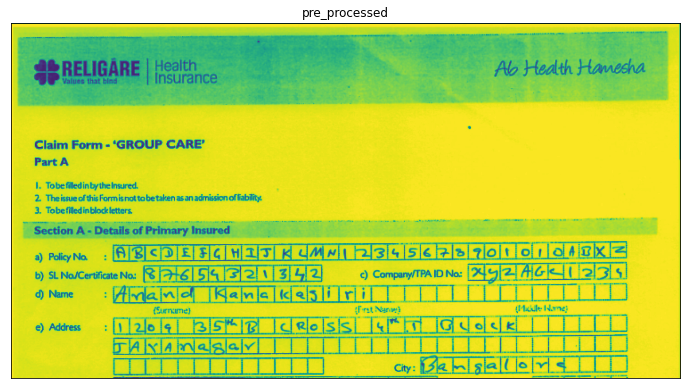

In [3]:
image = cv2.imread("outfile.png")
image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.xticks([]), plt.yticks([]) 
plt.title('pre_processed')
plt.show()

Coordinates for individual boxes (just for trial): <br>
A <br>
129,281<br>
146,281<br>
129,297<br>
146,297<br>
<br>
B<br>
150,281<br>
170,281<br>
150,299<br>
170,299<br>

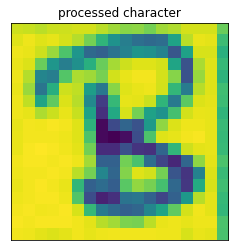

In [7]:
character = image[281:299,150:168] #cv2.bitwise_not(output)[281:297,129:146] #
fig = plt.figure(figsize=(6, 4))
plt.imshow(character)
plt.xticks([]), plt.yticks([]) 
plt.title('processed character')
plt.show()

### This gets the individual boxes for each of the fields

In [8]:
dim = 20
policy_id = []
tpa_id = []
name = []

# For Policy_ID
for i in range(32):
    box_top = 280
    box_left = 130+(i*dim)
    box_bot = 300
    box_right = 130+((i+1)*dim)
    
    character = image[box_top:box_bot, box_left:box_right]
    policy_id.append(character)

# For TPA_ID
for j in range(10):
    box_top = 305
    box_left = 575+(j*20)
    box_bot = 325
    box_right = 575+((j+1)*20)
    
    character = image[box_top:box_bot, box_left:box_right]
    tpa_id.append(character)

# For name
for k in range(32):
    box_top = 333
    box_left = 129+(k*dim)
    box_bot = 353
    box_right = 129+((k+1)*dim)
    
    character = image[box_top:box_bot, box_left:box_right]    
    name.append(character)

### Transfer Learning model trained on the MNIST digits and ENIST Alphabets dataset

In [9]:
# download the model from here: https://github.com/shivamgupta7/OCR-Handwriting-Recognition

model = load_model('handwriting.model')

In [10]:
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   576         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d[0][0]                     
_____________________________________________________________________________________________

In [11]:
def predict_label(gray):    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # perform edge detection, find contours in the edge map, and sort the
    # resulting contours from left-to-right
    edged = cv2.Canny(blurred, 30, 150)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    # initialize the list of contour bounding boxes and associated
    # characters that we'll be OCR'ing
    chars = []

    # loop over the contours
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)

        # filter out bounding boxes, ensuring they are neither too small
        # nor too large
        if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
            # extract the character and threshold it to make the character
            # appear as *white* (foreground) on a *black* background, then
            # grab the width and height of the thresholded image
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255,
                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (tH, tW) = thresh.shape

            # if the width is greater than the height, resize along the
            # width dimension
            if tW > tH:
                thresh = imutils.resize(thresh, width=32)

            # otherwise, resize along the height
            else:
                thresh = imutils.resize(thresh, height=32)

            # re-grab the image dimensions (now that its been resized)
            # and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)

            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))

            # prepare the padded image for classification via our
            # handwriting OCR model
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)

            # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))

    # extract the bounding box locations and padded characters
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype="float32")

    # OCR the characters using our handwriting recognition model
    preds = model.predict(chars)

    # define the list of label names
    labelNames = "0123456789"
    labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    labelNames = [l for l in labelNames]

    # loop over the predictions and bounding box locations together
    for (pred, (x, y, w, h)) in zip(preds, boxes):
        # find the index of the label with the largest corresponding
        # probability, then extract the probability and label
        i = np.argmax(pred)
        prob = pred[i]
        label = labelNames[i]
        print("[INFO] {} - {:.2f}%".format(label, prob * 100))
        return label


### Predicting individual chracters

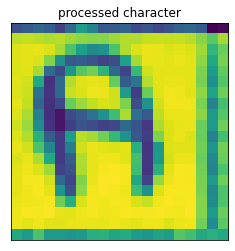

[INFO] A - 37.82%


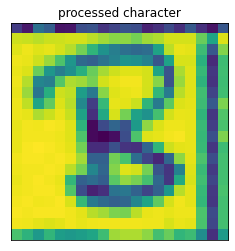

[INFO] B - 99.54%


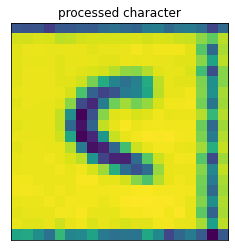

[INFO] E - 61.61%


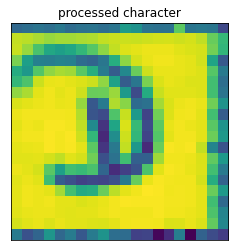

[INFO] N - 32.51%


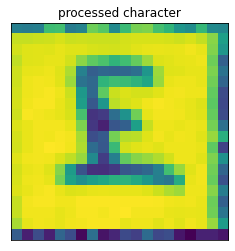

[INFO] Z - 47.19%


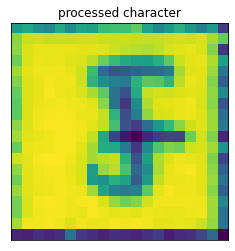

[INFO] 3 - 48.74%


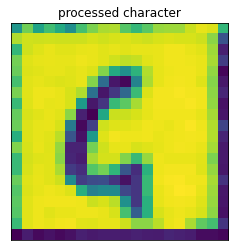

[INFO] G - 66.00%


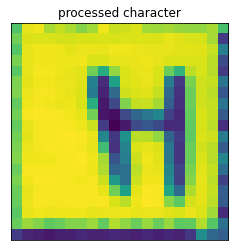

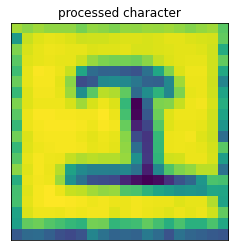

[INFO] I - 23.79%


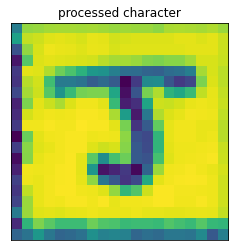

[INFO] 3 - 44.13%


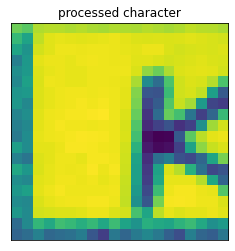

[INFO] K - 44.74%


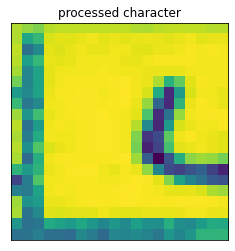

[INFO] 4 - 51.67%


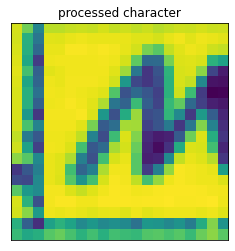

[INFO] R - 53.79%


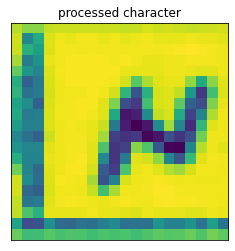

[INFO] G - 12.97%


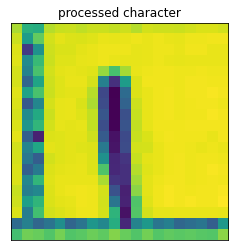

[INFO] 1 - 76.96%


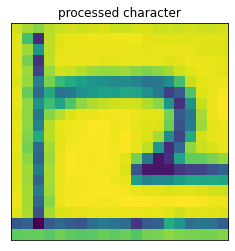

[INFO] Z - 52.14%


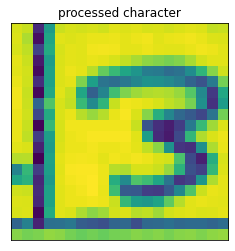

[INFO] B - 95.96%


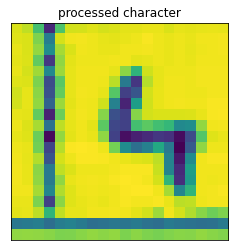

[INFO] 4 - 40.83%


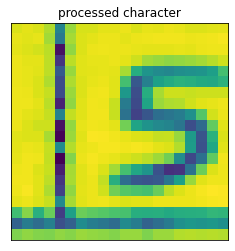

[INFO] 5 - 57.78%


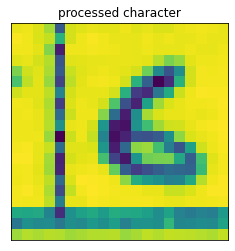

[INFO] E - 51.48%


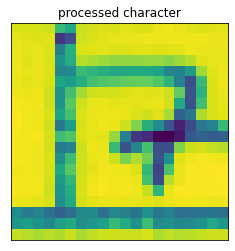

[INFO] B - 84.17%


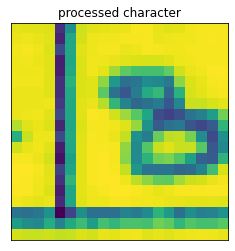

[INFO] B - 98.10%


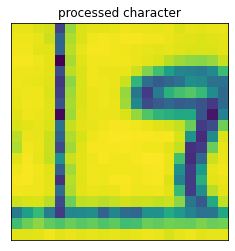

[INFO] 2 - 36.37%


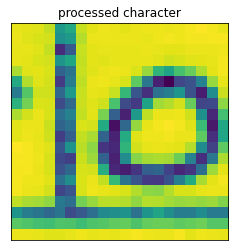

[INFO] B - 93.48%


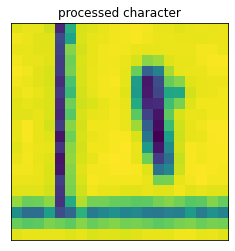

[INFO] U - 47.91%


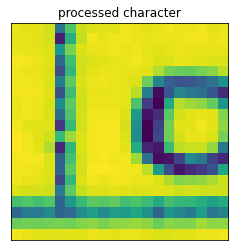

[INFO] 6 - 31.70%


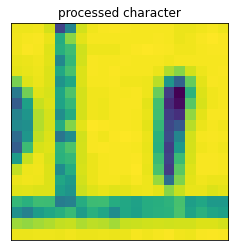

[INFO] 1 - 63.87%


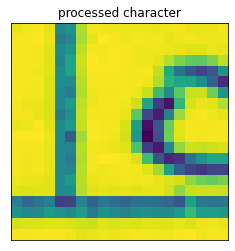

[INFO] 1 - 22.38%


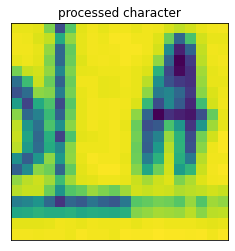

[INFO] M - 36.13%


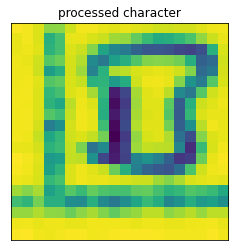

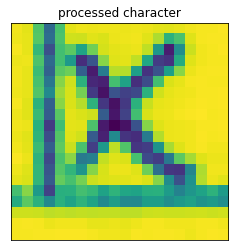

[INFO] B - 60.74%


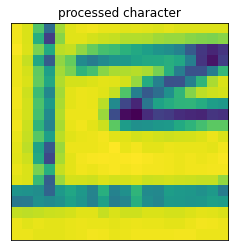

[INFO] B - 87.78%


In [12]:
policy = []
for character in policy_id:
    
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(character)
    plt.xticks([]), plt.yticks([]) 
    plt.title('processed character')
    plt.show()
    
    
    try:
        policy.append(predict_label(character))
    except:
        pass

In [14]:
print('Policy ID: ',''.join(policy))

Policy ID:  ABENZ3GI3K4RG1ZB45EBB2BU611MBB


# $2^{nd}$ Approach

## Using box detection to gather the boxes

#### USE:  pip install boxdetect

In [15]:
from boxdetect import config
from boxdetect.pipelines import get_boxes

In [16]:
new_image = np.zeros(image.shape)
# contrasting the black out for the handwriting
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
            if image[i][j] < 220:
                new_image[i][j] = 0
            else:
                new_image[i][j] = 255

cv2.imwrite('gray_image.png', new_image)
cv2.imshow('processed', new_image)
cv2.waitKey(0) #maximize the image from taskbar if cannot view it

-1

In [17]:
cfg = config.PipelinesConfig()
boxes = []

for i in range(19,25):
    for j in range(19,25):
        boxes.append((i,j))

cfg.autoconfigure(boxes)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [19]:
file_name = 'gray_image.png'
rects, grouping_rects, image, output_image = get_boxes(file_name, cfg=cfg, plot=False)

Processing file:  gray_image.png


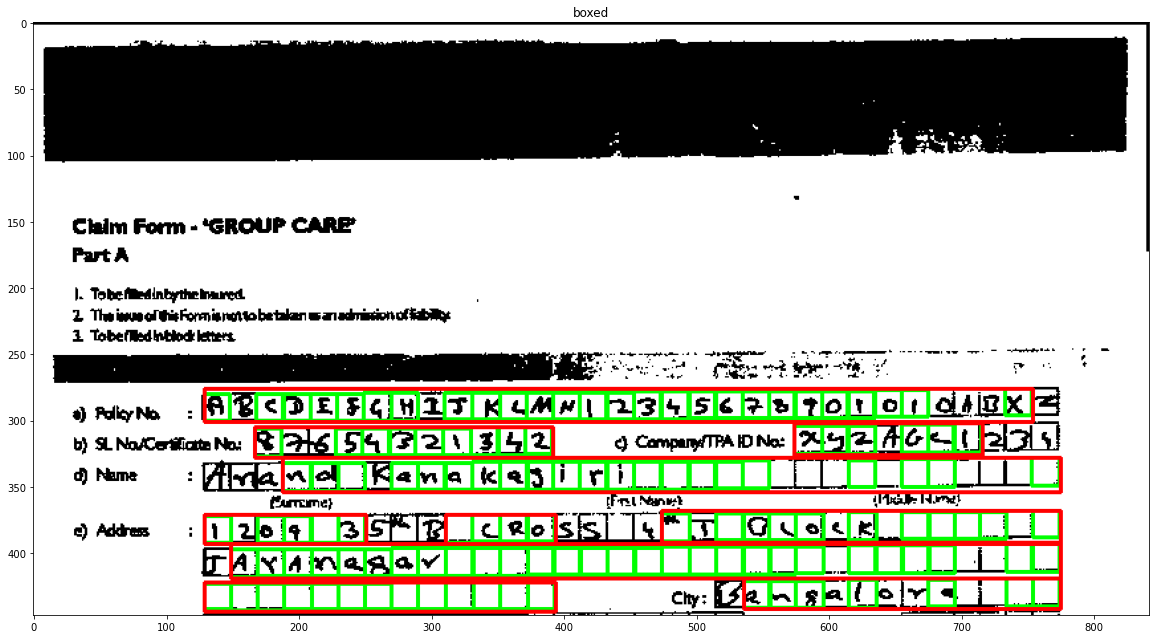

In [20]:
fig = plt.figure(figsize=(20,15))
plt.imshow(output_image)
plt.title('boxed')
plt.show()
#cv2.imshow('boxed', output_image)
#cv2.waitKey(0)

In [21]:
print(grouping_rects)

[(129, 276, 625, 25), (167, 305, 225, 23), (574, 302, 142, 24), (188, 328, 587, 26), (129, 371, 122, 22), (311, 371, 83, 22), (474, 368, 301, 24), (149, 393, 626, 26), (129, 422, 265, 22), (536, 419, 239, 23)]


In [22]:
field_values = {}
for i in [0,2,3]:    
    x,y,w,h = grouping_rects[i]
    x1,y1 = x,y
    x2,y2 = x+w, y+h
    if i == 0:
        field_values["policy_id"]= new_image[y1:y2, x1:x2]
    elif i == 2:
        field_values["tpa_id"]= new_image[y1:y2, x1:x2]
    else:
        field_values["name"]= new_image[y1:y2, x1:x2]

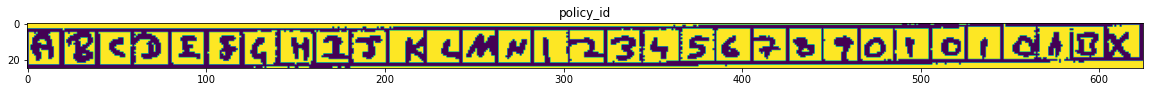

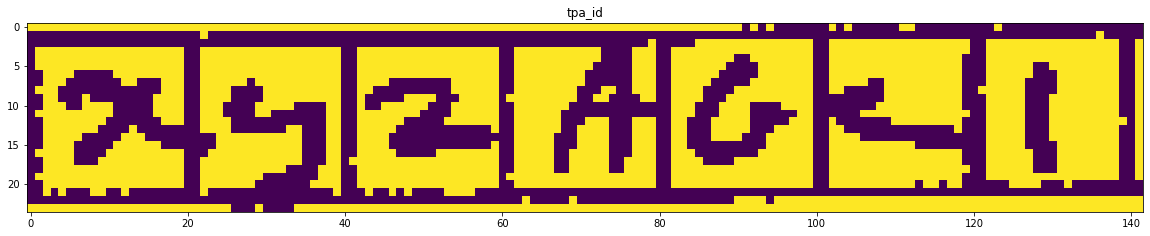

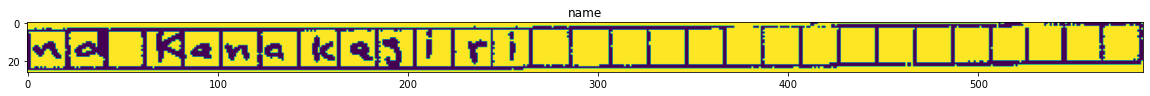

In [23]:
for key,box in field_values.items():

    fig = plt.figure(figsize=(20,4))
    plt.imshow(box)
    plt.title(key)
    plt.show()
    #cv2.imshow('boxed', box)
    #cv2.waitKey(0)